# Long Short Term Memory Networks for IoT Prediction

RNNs and LSTM models are very popular neural network architectures when working with sequential data, since they both carry some "memory" of previous inputs when predicting the next output. In this assignment we will continue to work with the Household Electricity Consumption dataset and use an LSTM model to predict the Global Active Power (GAP) from a sequence of previous GAP readings. You will build one model following the directions in this notebook closely, then you will be asked to make changes to that original model and analyze the effects that they had on the model performance. You will also be asked to compare the performance of your LSTM model to the linear regression predictor that you built in last week's assignment.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [2]:

import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages


# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

#from sklearn import preprocessing
#from sklearn.metrics import confusion_matrix, recall_score, precision_score
#from sklearn.model_selection import train_test_split
#from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Activation
from keras.utils import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM

In [3]:
#use this cell to import additional libraries or define helper functions

## Load and prepare your data

We'll once again be using the cleaned household electricity consumption data from the previous two assignments. I recommend saving your dataset by running df.to_csv("filename") at the end of assignment 2 so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

Unlike when using Linear Regression to make our predictions for Global Active Power (GAP), LSTM requires that we have a pre-trained model when our predictive software is shipped (the ability to iterate on the model after it's put into production is another question for another day). Thus, we will train the model on a segment of our data and then measure its performance on simulated streaming data another segment of the data. Our dataset is very large, so for speed's sake, we will limit ourselves to 1% of the entire dataset.

**TODO: Import your data, select the a random 1% of the dataset, and then split it 80/20 into training and validation sets (the test split will come from the training data as part of the tensorflow LSTM model call). HINT: Think carefully about how you do your train/validation split--does it make sense to randomize the data?**

In [5]:
#Load your data into a pandas dataframe here
df = pd.read_csv(r'C:\Users\hisaj\Downloads\cleaned_power_consumption_with_unix.csv')
#convert datetime to epoch/unix time
df['unix'] = (pd.to_datetime(df.Datetime)- pd.to_datetime('1970-01-01')).dt.total_seconds()
df['unix'].head()


0    1.166290e+09
1    1.166290e+09
2    1.166290e+09
3    1.166290e+09
4    1.166290e+09
Name: unix, dtype: float64

In [6]:
#create your training and validation sets here
#assign size for data subset
df_size = round(len(df)/100)
#take random data subset
start = np.random.choice(range(0,len(df)-df_size))
df_small = df.iloc[start:start+df_size].reset_index()

#take random data subset

#split data subset 80/20 for train/validation
split_point = round(len(df_small)*0.8)
train_df = df_small.iloc[:split_point]
val_df = df_small.iloc[split_point:]


In [7]:

#reset the indices for cleanliness

train_df = train_df.reset_index()
val_df = val_df.reset_index()


Next we need to create our input and output sequences. In the lab session this week, we used an LSTM model to make a binary prediction, but LSTM models are very flexible in what they can output: we can also use them to predict a single real-numbered output (we can even use them to predict a sequence of outputs). Here we will train a model to predict a single real-numbered output such that we can compare our model directly to the linear regression model from last week.

**TODO: Create a nested list structure for the training data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output**

In [9]:
seq_arrays = []
seq_labs = []

In [10]:

# we'll start out with a 20 minute input sequence and a one minute predictive horizon
seq_length = 60*20
ph = 60
feat_cols = ['Global_active_power']
#create list of sequence length GAP readings
for start in range(0,len(train_df)-seq_length-ph):
    seq_arrays.append(train_df[feat_cols].iloc[start:start+seq_length].to_numpy())
    seq_labs.append(train_df['Global_active_power'].iloc[start+seq_length+ph])

#convert to numpy arrays and floats to appease keras/tensorflow
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)
assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length,len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))
seq_arrays.shape



(15342, 1200, 1)

**Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?**

A:These assert statements help to double check that our code outputs arrays of the correct shape/size. We use assert statements in our code to ensure that it is functioning as we expect it to–this helps with debugging during the development process and can be used to produce more mature exception-handling code before putting the code into production. 

## Model Training

We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a LINEAR final layer and MSE for our loss function, since our output is continuous instead of binary.

**TODO: Fill in all values marked with a ?? in the cell below**

In [12]:

# define path to save model
model_path = 'LSTM_model1.keras'
# build the network
nb_features = len(feat_cols) #number of features included in the training data
nb_out = 1 #expected output length
model = Sequential()
#add first LSTM layer
model.add(LSTM(
input_shape=(seq_length, nb_features), #shape of input layer
units=5, #number of hidden units
return_sequences=True))
model.add(Dropout(0.2)) #dropout for regularization
# add second LSTM layer
model.add(LSTM(
units=3,
return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
print(model.summary())
# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500,validation_split=0.05, verbose=2,
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=10, verbose=0, mode='min'),
keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True,mode='min', verbose=0)])
# list all data in history
print(history.history.keys())

C:\Users\hisaj\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1200, 5)             │             140 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1200, 5)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 3)                   │             108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               4 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 252 (1008.00 B)

 Trainable params: 252 (1008.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
30/30 - 28s - 934ms/step - loss: 2.0248 - mse: 2.0248 - val_loss: 2.4720 - val_mse: 2.4720
Epoch 2/100
30/30 - 21s - 708ms/step - loss: 1.5847 - mse: 1.5847 - val_loss: 2.6450 - val_mse: 2.6450
Epoch 3/100
30/30 - 21s - 693ms/step - loss: 1.5053 - mse: 1.5053 - val_loss: 2.3773 - val_mse: 2.3773
Epoch 4/100
30/30 - 42s - 1s/step - loss: 1.2569 - mse: 1.2569 - val_loss: 1.9512 - val_mse: 1.9512
Epoch 5/100
30/30 - 23s - 772ms/step - loss: 1.2071 - mse: 1.2071 - val_loss: 1.9380 - val_mse: 1.9380
Epoch 6/100
30/30 - 20s - 652ms/step - loss: 1.2018 - mse: 1.2018 - val_loss: 1.9740 - val_mse: 1.9740
Epoch 7/100
30/30 - 19s - 639ms/step - loss: 1.1920 - mse: 1.1920 - val_loss: 1.9987 - val_mse: 1.9987
Epoch 8/100
30/30 - 20s - 674ms/step - loss: 1.1726 - mse: 1.1726 - val_loss: 1.9441 - val_mse: 1.9441
Epoch 9/100
30/30 - 19s - 643ms/step - loss: 1.1649 - mse: 1.1649 - val_loss: 1.9542 - val_mse: 1.9542
Epoch 10/100
30/30 - 19s - 636ms/step - loss: 1.1675 - mse: 1.1675 - va

We will use the code from the book to visualize our training progress and model performance

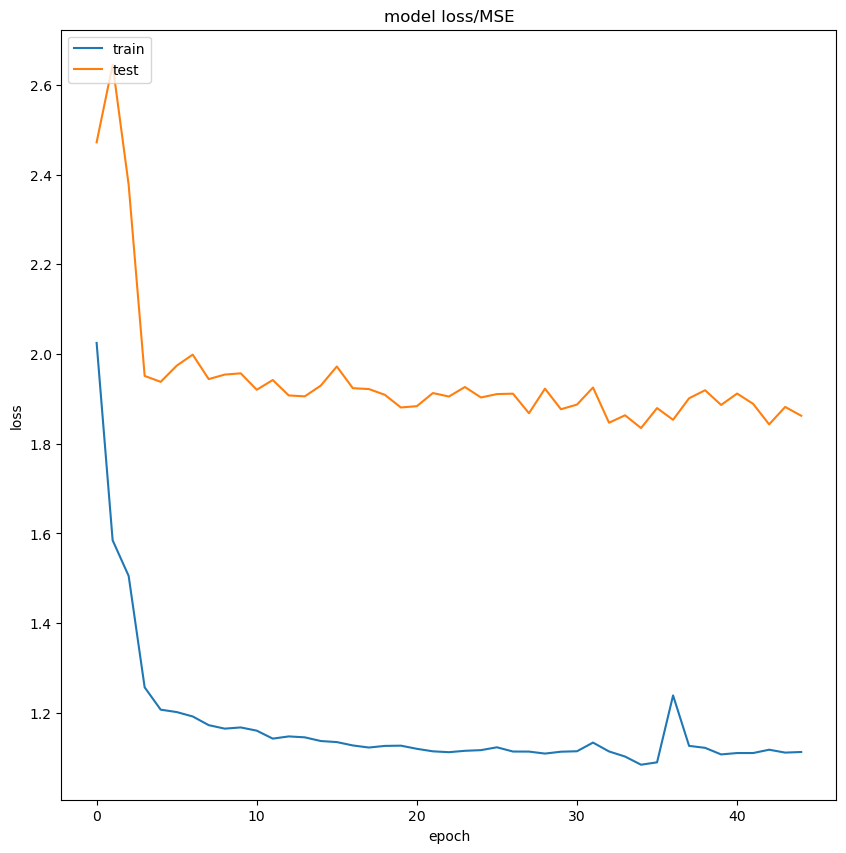

In [14]:
# summarize history for Loss/MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss/MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")


## Validating our model

Now we need to create our simulated streaming validation set to test our model "in production". With our linear regression models, we were able to begin making predictions with only two datapoints, but the LSTM model requires an input sequence of *seq_length* to make a prediction. We can get around this limitation by "padding" our inputs when they are too short.

**TODO: create a nested list structure for the validation data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output. Begin your predictions after only two GAP measurements are available, and check out [this keras function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) to automatically pad sequences that are too short.**

**Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?**

A: The pad_sequences function adds a dummy value to the input sequence until it reaches the required sequence length. These dummy values can be added to the beginning or end of the input sequence with the “padding” argument, and the default setting (padding the beginning of the sentence) makes the most sense for our use case since we want the most recent reading to occur at the end of the input sequence.

In [16]:

val_arrays = []
val_labs = []
#create list of GAP readings starting with a minimum of two readings
for end in range(2, len(val_df)-ph):
#add short sequences until we reach the sequence length
    if end < seq_length:
        val_arrays.append(val_df[feat_cols][0:end].to_numpy())
        val_labs.append(val_df['Global_active_power'][end+ph])
 #add sequences of seq_length once we have enough data
    else:
        val_arrays.append(val_df[feat_cols][end-seq_length:end].to_numpy())
        val_labs.append(val_df['Global_active_power'][end+ph])

# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32
val_arrays = pad_sequences(val_arrays, maxlen = seq_length, dtype = np.float32)
#convert to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)



We will now run this validation data through our LSTM model and visualize its performance like we did on the linear regression data.

128/128 - 15s - 115ms/step - loss: 1.4046 - mse: 1.4046

MSE: 1.4045780897140503
128/128 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step


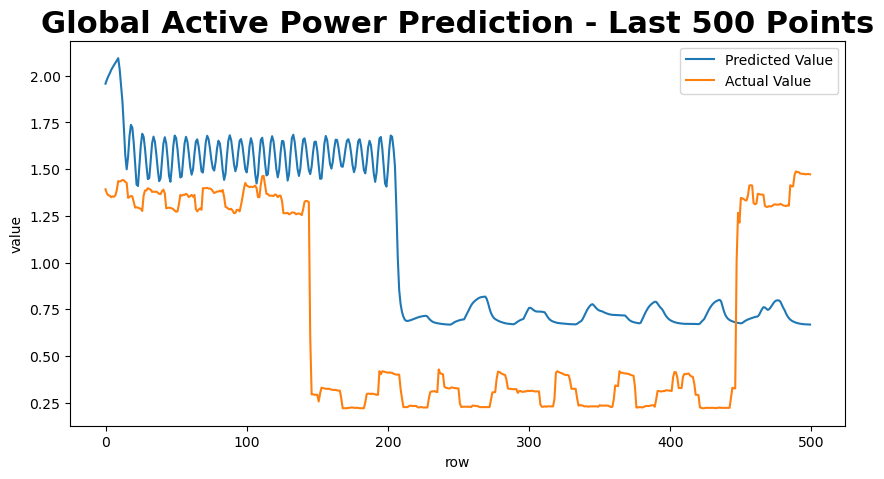

In [18]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))
y_pred_test = model.predict(val_arrays)
y_true_test = val_labs
test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)
# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22,fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
# Set custom Y-axis scale
#plt.yticks([1, 2, 3, 4, 5, 6])
plt.legend()
plt.show()
fig_verify.savefig('model_regression_verify.png')


**Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?**

A: : This model does not perform very well, especially when compared to the simple linear regression model that we built last week. We can see from the loss curves that that the training loss continues to improve until the early stopping limit kicks in, but the test loss is largely unchanged throughout training. This could
signify many problems, including: - we could be overfitting the training data, though we’d expect to see the training loss decrease until it actually performs better than the validation loss (also, our two dropout layers should help us avoid overfitting) - our test data might not be well-represented in the training data (this is unlikely since the train/test sequences are chosen randomly) - we might need to use a larger training dataset - we might need to give our model more predictive power (i.e. increase the number of trainable parameters/hidden layers) - we might need to simplify our model (i.e. reduce the number of trainable parameters/hidden layers) - we might need to optimize our model hyperparameters (e.g. learning rate, optimizier, etc.)



## Model Optimization

Now it's your turn to build an LSTM-based model in hopes of improving performance on this training set. Changes that you might consider include:

- Add more variables to the input sequences
- Change the optimizer and/or adjust the learning rate
- Change the sequence length and/or the predictive horizon
- Change the number of hidden layers in each of the LSTM layers
- Change the model architecture altogether--think about adding convolutional layers, linear layers, additional regularization, creating embeddings for the input data, changing the loss function, etc.

There isn't any minimum performance increase or number of changes that need to be made, but I want to see that you have tried some different things. Remember that building and optimizing deep learning networks is an art and can be very difficult, so don't make yourself crazy trying to optimize for this assignment.

**Q: What changes are you going to try with your model? Why do you think these changes could improve model performance?**

 I’m going to use a Wavenet-like architecture, where I add several convolutional layers to the model before I run it through an LSTM layer. This architecture has been particularly successful on audio data inputs, and while our data isn’t quite as noisy/cyclical as audio data, it’s an interesting model that is intended to be used on high-frequency sequential data, so I want to see how it compares to a more standard LSTM architecture.A:

C:\Users\hisaj\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 1200, 32)            │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1200, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 1200, 48)            │           3,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1200, 48)            │             192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 1200, 64)            │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1200, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100)                 │          66,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             101 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 76,101 (297.27 KB)

 Trainable params: 75,813 (296.14 KB)

 Non-trainable params: 288 (1.12 KB)

None
Epoch 1/100
146/146 - 297s - 2s/step - loss: 1.1546 - mse: 1.1546 - val_loss: 1.9819 - val_mse: 1.9819
Epoch 2/100
146/146 - 357s - 2s/step - loss: 1.0717 - mse: 1.0717 - val_loss: 1.9691 - val_mse: 1.9691
Epoch 3/100
146/146 - 349s - 2s/step - loss: 1.0077 - mse: 1.0077 - val_loss: 1.6985 - val_mse: 1.6985
Epoch 4/100
146/146 - 385s - 3s/step - loss: 0.9607 - mse: 0.9607 - val_loss: 1.8680 - val_mse: 1.8680
Epoch 5/100
146/146 - 356s - 2s/step - loss: 0.9676 - mse: 0.9676 - val_loss: 1.9079 - val_mse: 1.9079
Epoch 6/100
146/146 - 379s - 3s/step - loss: 0.8609 - mse: 0.8609 - val_loss: 2.0703 - val_mse: 2.0703
Epoch 7/100
146/146 - 381s - 3s/step - loss: 0.7795 - mse: 0.7795 - val_loss: 2.1587 - val_mse: 2.1587
Epoch 8/100
146/146 - 351s - 2s/step - loss: 0.7614 - mse: 0.7614 - val_loss: 2.5499 - val_mse: 2.5499
Epoch 9/100
146/146 - 321s - 2s/step - loss: 0.7118 - mse: 0.7118 - val_loss: 3.0919 - val_mse: 3.0919
Epoch 10/100
146/146 - 332s - 2s/step - loss: 0.6636 - mse: 0.6636 -

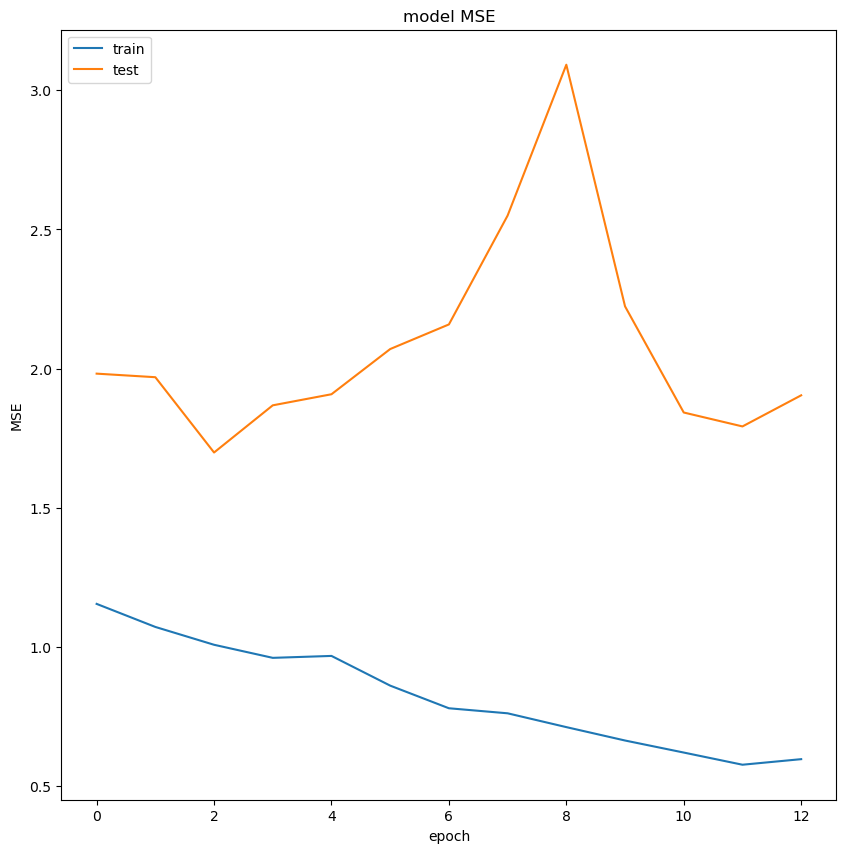

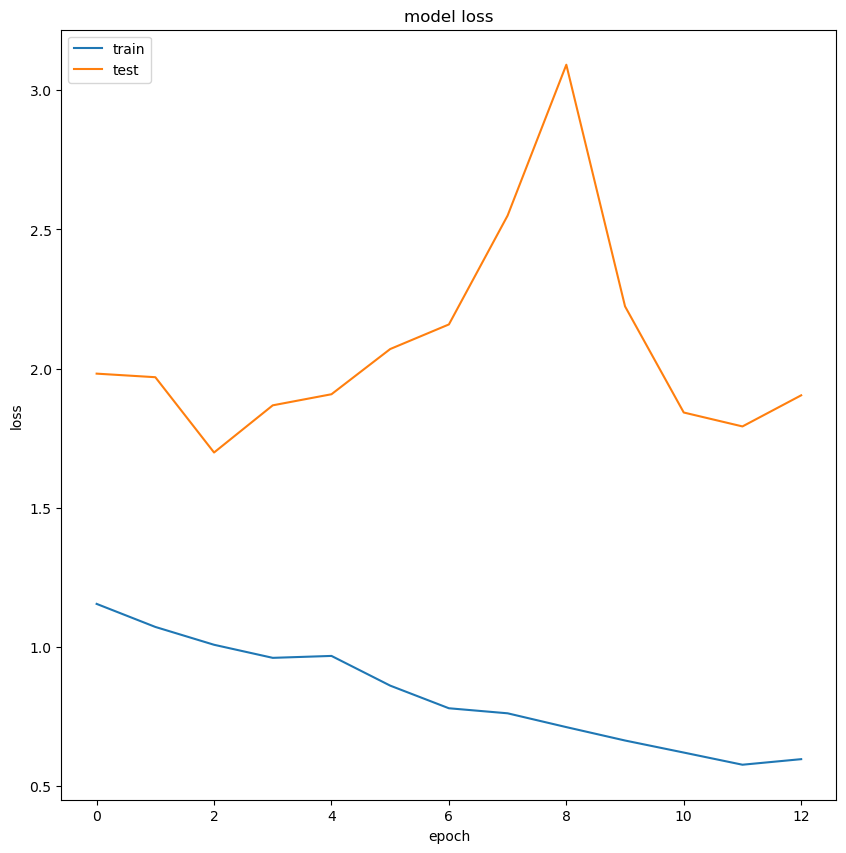

In [20]:

# play with your ideas for optimization here
from keras.layers import Conv1D, BatchNormalization
# define path to save model
model_path = 'LSTM_model2.keras'
# build the network
nb_features = len(feat_cols) #number of features included in the training data
nb_out = 1 #expected output length
model = Sequential()
#add first LSTM layer
model.add(Conv1D(32,
input_shape=(seq_length, nb_features),
kernel_size=2, padding="causal",
activation="relu"))
model.add(BatchNormalization())
model.add(Conv1D(48,
kernel_size=2,
padding="causal",
activation="relu",
dilation_rate=2))
model.add(BatchNormalization())
model.add(Conv1D(64,
kernel_size=2,
padding="causal",
activation="relu",
dilation_rate=4))
model.add(BatchNormalization())
model.add(LSTM(100))
model.add(Dense(units = nb_out))
model.add(Activation("linear"))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
print(model.summary())

# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=100,validation_split=0.05, verbose=2,
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=10, verbose=0, mode='min'),
keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True,mode='min', verbose=0)])
# list all data in history
print(history.history.keys())

# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig('LSTM_rmse2.png')

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig('LSTM_loss2.png')



128/128 - 30s - 234ms/step - loss: 1.7040 - mse: 1.7040

MSE: 1.703996181488037
128/128 ━━━━━━━━━━━━━━━━━━━━ 33s 253ms/step


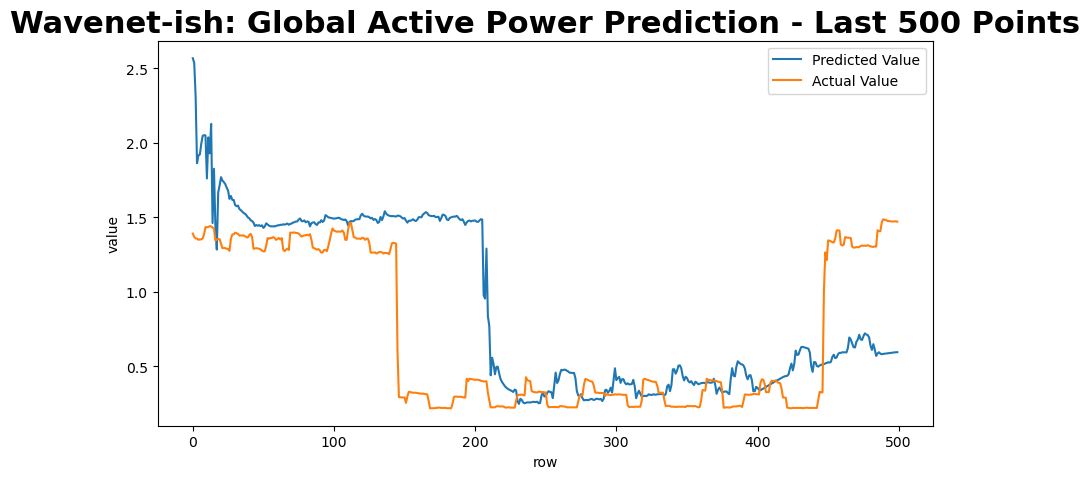

In [21]:
# show me how one or two of your different models perform 
# using the code from the "Validating our model" section above

scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))
y_pred_test = model.predict(val_arrays)
y_true_test = val_labs
test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)
# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Wavenet-ish: Global Active Power Prediction - Last 500 Points',fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

**Q: How did your model changes affect performance on the validation data? Why do you think they were/were not effective? If you were trying to optimize for production, what would you try next?**

A: The model training was more effective and smoother, but the loss curves here look much more indicative of overfitting. This shouldn’t be too surprising given that this model has about 5x the parameters of our earlier model and the number of sequences in our training data. Certainly the next step would be to re-train either of these models with much more data and/or to drastically decrease the complexity of the models. Ideally we’d use the entire 3-month dataset, though that would take quite a bit of compute and time to train. If we decreased the model complexity, we run the risk of not giving the model enough flexibility to learn to predict the data well.

**Q: How did the models that you built in this assignment compare to the linear regression model from last week? Think about model performance and other IoT device considerations; Which model would you choose to use in an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, and why?**

A: The linear regression model was more effective at predicting the GAP with a predictive horizon of 5 minutes than any of the LSTM models that I built, by far. Given that the performance of the linear regression model was better AND the model would be much lighter weight, easier to maintain, and could even run directly on an edge device, there’s no question that I would choose the linear regression model given the models that I’ve produced so far. That said, the linear regression model was not perfect, especially as we increased the predictive horizon, so I’d still want to play with other deep learning architectures before I made a final decision.